In [101]:
import xobjects as xo
import xpart as xp
import xcoll as xc
import numpy as np
import xtrack as xt
import pickle

import matplotlib.pyplot as plt

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 14
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [102]:
num_part = 5000

# Make a transfer line
# ====================
k_qf_1 = 0.32730047
k_qd_2 = -0.36102915
k_qf_3 = 0.32789126
k_qd_4 = -0.1991137
l_quad = 2

elements = [
            xt.Quadrupole(k1=k_qf_1, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_2, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qf_3, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_4, length=l_quad),
            xt.Drift(length=89.),
            xt.Marker(),
            xt.Multipole(length=1.0, knl=[0.0])
           ]
element_names = ["QF1", "drift_1", "QD2", "drift_2", "QF3", "drift_3", "QD4",
                 "drift_4", "END", "fake_multipole"]
particle_ref = xp.Particles(energy0=24.e9)
line = xt.Line(elements=elements, element_names=element_names, particle_ref=particle_ref)

# Add air regions
# ===============


air = xc.Material(name="Air",
                Z = 7.5,
                A = 28.97,
                density = 0.001225,
                excitation_energy = 85.7e-9,
                hcut = 0.01,
                nuclear_radius = 0.366,
                radiation_length = 301,
                nuclear_elastic_slope = 217.8,
                cross_section = [1.253, 0.769, 0, 0, 0, 0.1530e-2]
                )

Carbon_modified = xc.Material(
        name = 'Carbon modified to be air-like',
        Z = 7.5,
        A = 28.97,
        density = 0.001225,
        excitation_energy = 85.7e-9,
        radiation_length = 301,
        nuclear_radius = 0.25,
        nuclear_elastic_slope = 70.0,
        cross_section = [0.337, 0.232, 0, 0, 0, 0.0076e-2]
)

line.insert_element(element=xc.EverestBlock(length=20, material=Carbon_modified), name="Air 1", at_s=40) #xc.materials.Carbon

# Add monitors
# ============
mon_air_1_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_1_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_2_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_2_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
line.insert_element(element=mon_air_1_s, name="monitor air 1 start", at_s=15)
line.insert_element(element=mon_air_1_e, name="monitor air 1 end", at_s=20)
line.insert_element(element=mon_air_2_s, name="monitor air 2 start", at_s=65)
line.insert_element(element=mon_air_2_e, name="monitor air 2 end", at_s=70)


# Generate an initial distribution of particles
# =============================================
line.build_tracker()

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [ ]:
np.unique(line.record_last_track.s.reshape(10000*21,))

array([  0.        ,   2.        ,   3.        ,   5.        ,
         6.        ,   8.        ,   9.        ,  11.        ,
        15.        ,  20.        ,  40.        ,  40.0423234 ,
        40.08497492,  40.86508044,  41.30149415,  41.45159962,
        41.51619181,  41.54955871,  41.57320677,  41.64804377,
        42.2003286 ,  42.70117128,  42.97899938,  43.17391001,
        43.50491317,  43.73064116,  44.11847563,  44.35980297,
        44.90242633,  45.04221653,  45.0423234 ,  45.08497492,
        45.64002876,  45.76174294,  45.80446191,  45.86508044,
        46.05002711,  46.30149415,  46.43042683,  46.45159962,
        46.51619181,  46.54955871,  46.57320677,  46.64804377,
        47.00925651,  47.13014089,  47.2003286 ,  47.70117128,
        47.72298624,  47.84173092,  47.97899938,  48.1170881 ,
        48.17391001,  48.2056038 ,  48.50491317,  48.61942569,
        48.73064116,  49.11847563,  49.35980297,  49.40014889,
        49.65426318,  49.90242633,  50.04221653,  50.04

In [103]:
line["Air 1"]._tracking = False
# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
dx0 = 0.13
dy0 = 0.0
dpx0 = 0.02
dpy0 = 0.0
tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init)

nemitt_x = 7.639770207283603e-06
nemitt_y = 3.534081877201574e-06
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()
line["Air 1"]._tracking = True

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [104]:
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

Text(0, 0.5, 'y [m]')

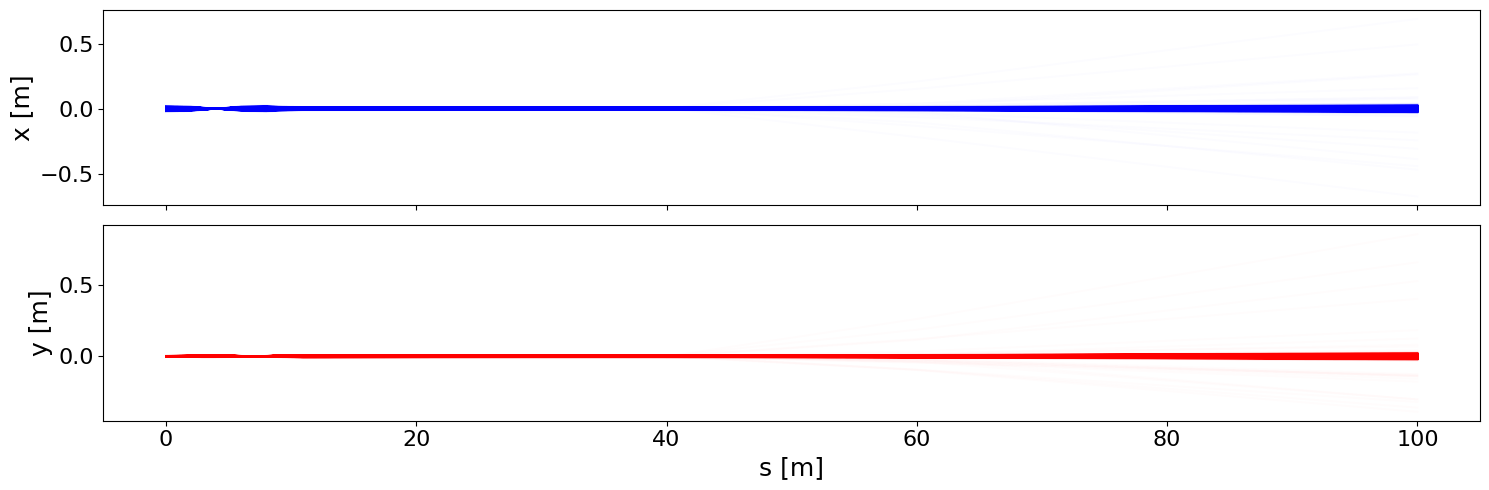

In [105]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

for i in range(len(line.record_last_track.s)):
    ax[0].plot(line.record_last_track.s[i], line.record_last_track.x[i], color='blue', alpha=0.01);
    ax[1].plot(line.record_last_track.s[i], line.record_last_track.y[i], color='red', alpha=0.01);

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')

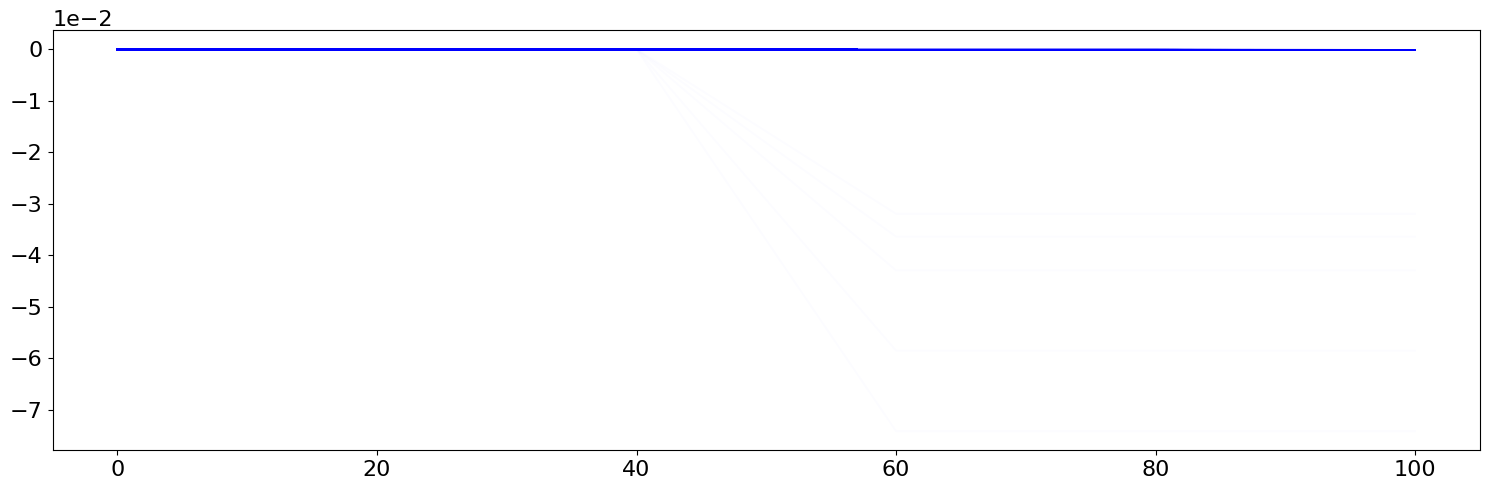

In [106]:
fig,ax = plt.subplots(figsize=(15,5), tight_layout=True, sharex=True)

for i in range(len(line.record_last_track.s)):
    ax.plot(line.record_last_track.s[i], line.record_last_track.delta[i], color='blue', alpha=0.01)

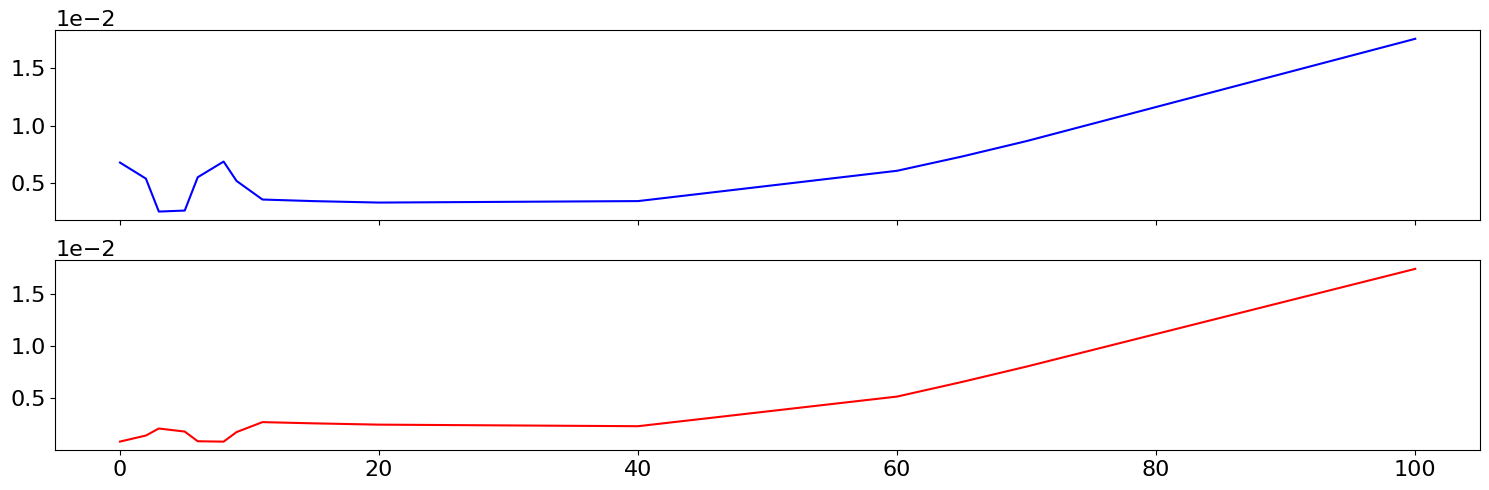

In [107]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

s_list = []
sigH_list = []
sigV_list = []

for i in range(len(tw.s)):
    s_list.append(tw.s[i])
    sigH_list.append(np.std(line.record_last_track.x[:,i]))
    sigV_list.append(np.std(line.record_last_track.y[:,i]))
ax[0].plot(s_list, sigH_list, c="b")
ax[1].plot(s_list, sigV_list, c="r")

import pandas as pd
d = {'s': s_list, 'sigH': sigH_list, 'sigV': sigV_list}
df = pd.DataFrame(data=d)

with open('xsuite_beam_size_full_int.p', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [108]:
# for i in range(len(tw.s)):
#     fig, ax = plt.subplots()
#     ax.set_title(f's={tw.s[i]}')
#     ax.hist(line.record_last_track.x[:,i], bins=200, range=(-0.05, 0.05))
#     ax.hist(line.record_last_track.y[:,i], bins=200, range=(-0.05, 0.05))
#     ax.set_xlim(-0.05, 0.05)

Text(0.5, 0, 's [m]')

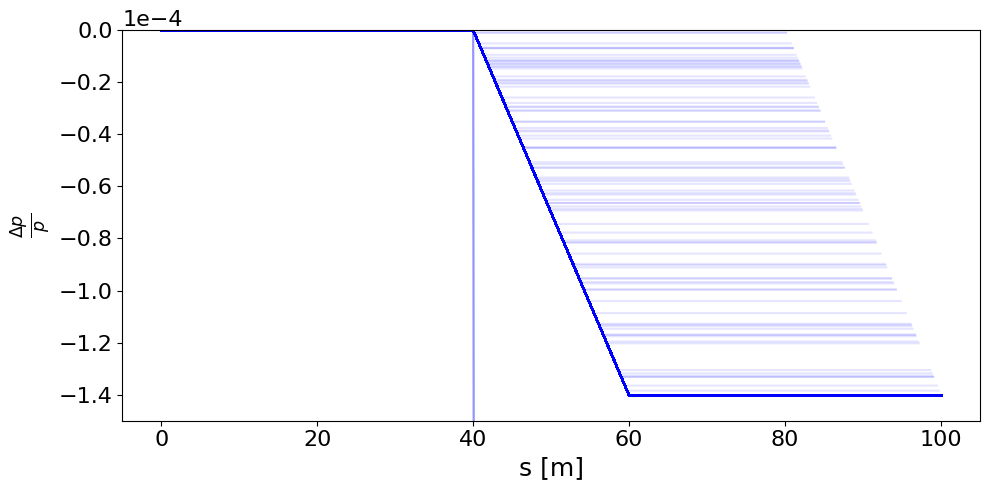

In [109]:
fig,ax = plt.subplots(figsize=(10,5), tight_layout=True)

for i in range(len(line.record_last_track.s)):
    ax.plot(line.record_last_track.s[i], line.record_last_track.delta[i], color='blue', alpha=0.1)

ax.set_ylim(-0.00015, 0.0)

ax.set_ylabel(r"$\frac{\Delta p}{p}$")
ax.set_xlabel('s [m]')

Text(0.5, 1.0, 'Distribution of $\\Delta p/p$ along the line')

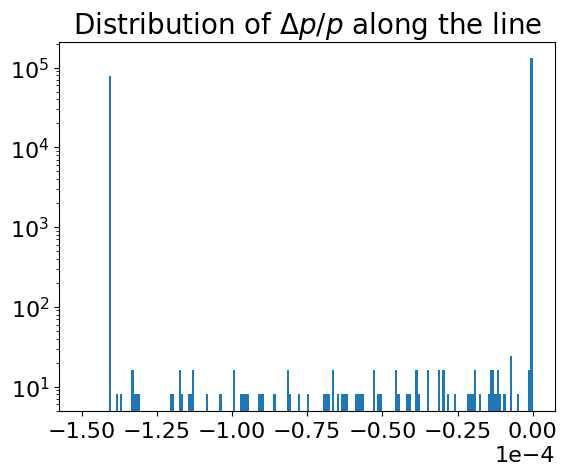

In [110]:
fig, ax = plt.subplots()
ax.hist(line.record_last_track.delta.reshape(10000*21,), bins = 200, range=(-0.00015, 0));
ax.set_yscale("log")
ax.set_title("Distribution of $\Delta p/p$ along the line")

# Compare with FLUKA

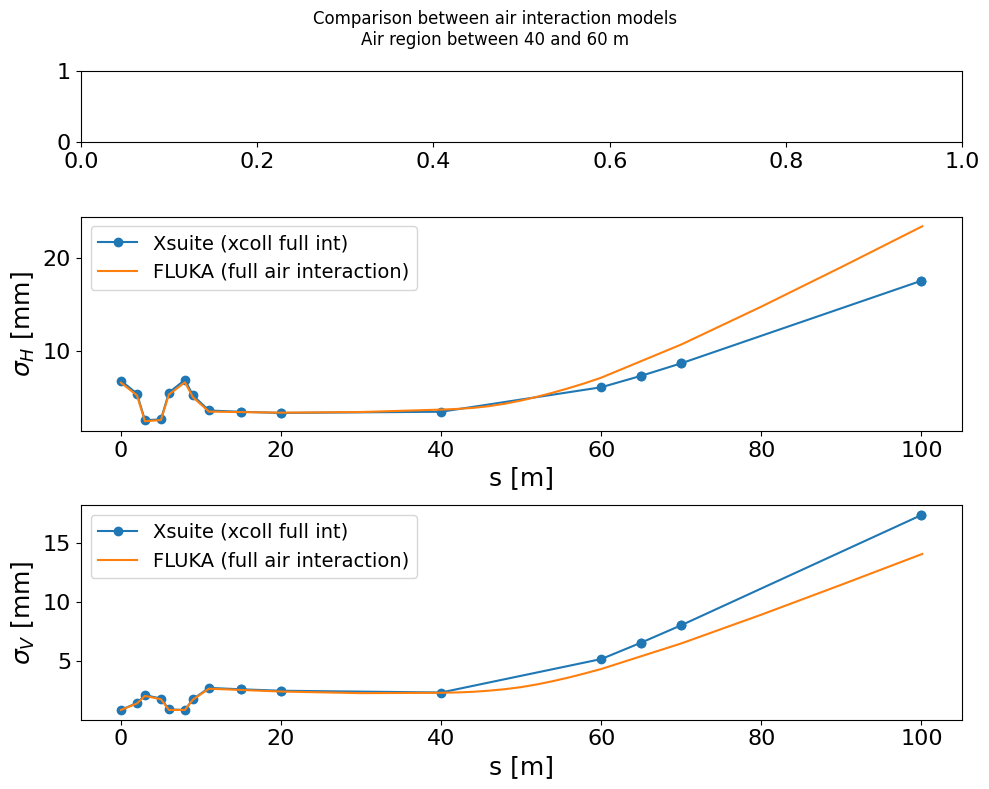

In [111]:
with open('xsuite_beam_size_full_int.p', 'rb') as f:
    df_xsuite_full_int = pickle.load(f)

with open('../data/FLUKA_data/airscattering.pickle', 'rb') as f:
    df_fluka_options = pickle.load(f)


fig, ax = plt.subplots(3,1, figsize=(10,8), tight_layout=True, height_ratios=[1, 3, 3])

ax[1].plot(df_xsuite_full_int.s, df_xsuite_full_int.sigH*1000, marker="o", label="Xsuite (xcoll full int)")
ax[2].plot(df_xsuite_full_int.s, df_xsuite_full_int.sigV*1000, marker="o", label="Xsuite (xcoll full int)")


#FLUKA options
ax[1].plot(df_fluka_options.Dist, df_fluka_options.X_air*10, label="FLUKA (full air interaction)")
ax[2].plot(df_fluka_options.Dist, df_fluka_options.Y_air*10, label="FLUKA (full air interaction)")


ax[1].set_xlabel("s [m]")
ax[1].set_ylabel(r"$\sigma_{H}$ [mm]")
ax[1].legend(loc="upper left")
# ax[0].set_ylim(0, 3)

ax[2].set_xlabel("s [m]")
ax[2].set_ylabel(r"$\sigma_{V}$ [mm]")
ax[2].legend()
# ax[1].set_ylim(0, 3)

fig.suptitle("Comparison between air interaction models\nAir region between 40 and 60 m")

plt.savefig("compare_simulation.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')